In [36]:
## Starting off with custom datasets
import os
import requests
import zipfile
from pathlib import Path

data_path =  Path('data')
image_path = data_path / 'images'

if image_path.is_dir():
    print(f"{image_path} .Direcotry already exists")
else:
    print(f"Creating direcotry. {image_path}")
    image_path.mkdir(parents=True, exist_ok=True) #* relative path
    
    #* Download the data
    with open(data_path / "Data.zip" , 'wb') as f :#* create file in write binary mode
        #* get the data from the url
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
        print("downloading data")
        f.write(request.content) #* write the content to the file
        
    #* Unzip the data
    with zipfile.ZipFile(data_path / "Data.zip", 'r') as zip_ref: #* read the zip file
        print('Unziping data')
        zip_ref.extractall(image_path) #* extract the data to the data_path
    

data\images .Direcotry already exists


In [37]:
for dir_path, dir_name, file_name in os.walk(image_path):
    print(f"There are {len(dir_name)} driectories and {len(file_name)} images in '{dir_path}'")

There are 2 driectories and 0 images in 'data\images'
There are 3 driectories and 0 images in 'data\images\test'
There are 0 driectories and 25 images in 'data\images\test\pizza'
There are 0 driectories and 19 images in 'data\images\test\steak'
There are 0 driectories and 31 images in 'data\images\test\sushi'
There are 3 driectories and 0 images in 'data\images\train'
There are 0 driectories and 78 images in 'data\images\train\pizza'
There are 0 driectories and 75 images in 'data\images\train\steak'
There are 0 driectories and 72 images in 'data\images\train\sushi'


In [38]:
os.listdir(image_path)
train_dir = image_path / os.listdir(image_path)[0]
test_dir = image_path / os.listdir(image_path)[1]
train_dir, test_dir

(WindowsPath('data/images/test'), WindowsPath('data/images/train'))

Random image path: data\images\train\pizza\3109486.jpg
Image class: pizza
Image height: 512
Image width: 512


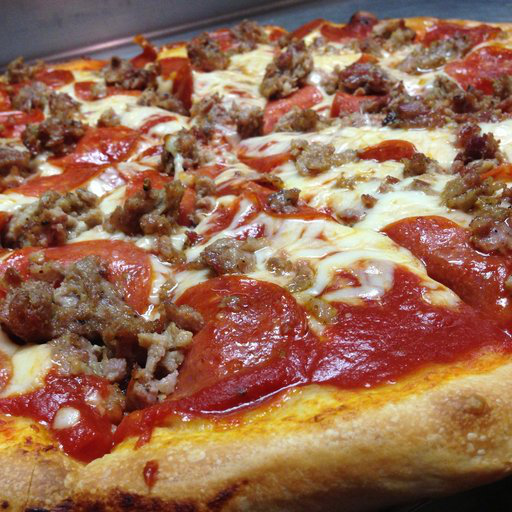

In [39]:
import random
import PIL

#random.seed(42)

#* get all images paths
image_path_list = list(image_path.glob(r"*/*/*.jpg"))

#* get a random image
random_image_path = random.choice(image_path_list)

#* get the image label
image_class = random_image_path.parent.name

#* open image
img = PIL.Image.open(random_image_path)

#* Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

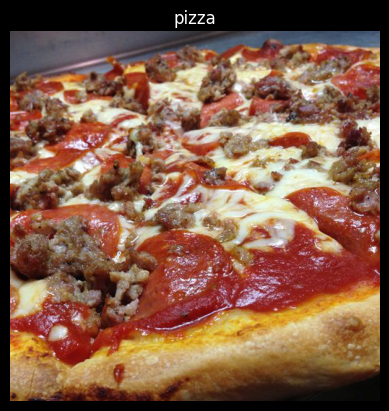

In [40]:
import numpy as np
import matplotlib.pyplot as plt


img_arr = np.asarray(img)
img_arr.shape, img_arr.dtype

plt.imshow(img_arr)
plt.title(image_class)
plt.axis(False)

## Transform 
- before using data we need to transform it to a format that is useful for our analysis
- from ndarray to tensor
- then we can trasnfrom it with the help of transforms

In [41]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [42]:
#* Compose transforms
#* compination of transforms

data_transfroms = transforms.Compose([
    #*1. Resize the image
    transforms.Resize(size=(64,64)),
    
    #*2. flip the images randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    
    #*3. change to tensor
    transforms.ToTensor()
])

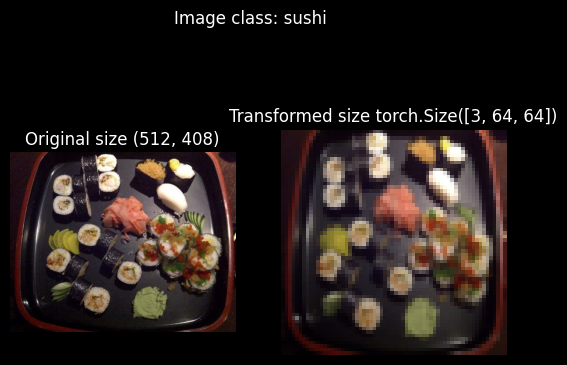

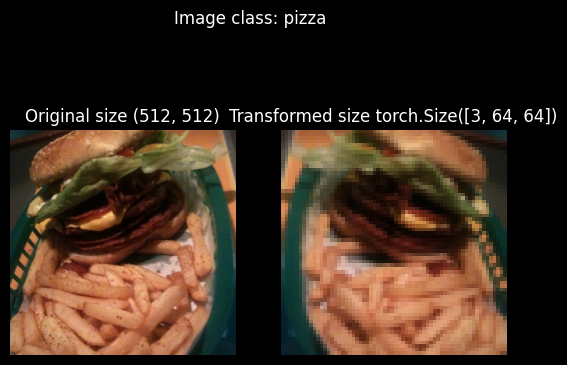

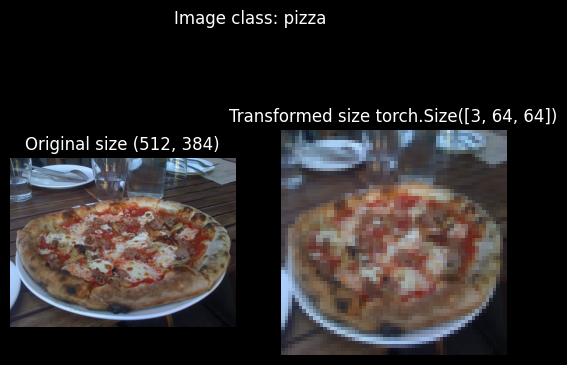

In [43]:
random.seed(42)
random_image_path = random.sample(image_path_list, 3)
for image in random_image_path:
    with PIL.Image.open(image) as f :
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original size {f.size}")
        ax[0].axis(False)
        
        transformed_image = data_transfroms(f)
        #* permute the tensor to change the channel dimension
        ax[1].imshow(transformed_image.permute(1,2,0))
        ax[1].set_title(f"Transformed size {transformed_image.shape}")
        ax[1].axis(False)
        
        fig.suptitle(f"Image class: {image.parent.name}")
        

In [44]:
data_transfroms(img).shape

torch.Size([3, 64, 64])

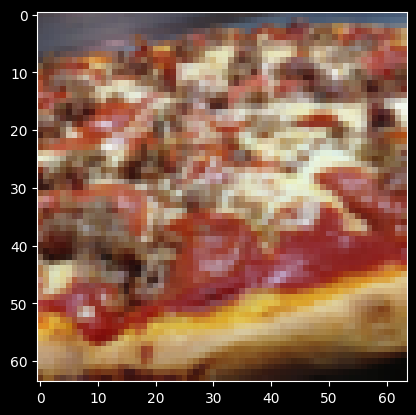

In [45]:
plt.imshow(data_transfroms(img).permute(1,2,0))

## Option 1 : ImageFolder

In [46]:
from torchvision.datasets import ImageFolder

#* similar to ImageGenerator in Keras

train_data  = ImageFolder(
    root=train_dir,
    transform=data_transfroms,
    target_transform=None,
)

test_data = ImageFolder(
    root=test_dir,
    transform=data_transfroms,
)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\images\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\images\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [48]:
train_data.class_to_idx, len(train_data), len(test_data)

({'pizza': 0, 'steak': 1, 'sushi': 2}, 75, 225)

In [52]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=1,
    num_workers=1,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=1,
    num_workers=1,
    shuffle=False
)

In [54]:
image, label = next(iter(train_dataloader))
image.shape

torch.Size([1, 3, 64, 64])

## Option 2 : subclassing Dataset